# CIFAR 100

## Install EfficientNet

In [0]:
!pip install -q efficientnet

## Detect Tensorflow Version

In [2]:
# for tensorflow v1
# %tensorflow_version 1.x

# for tensorflow v2
!pip install -U keras

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

     |████████████████████████████████| 378kB 38.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Tensorflow version 2.2.0-rc2


## Import Pretrained Model

In [0]:
import efficientnet.tfkeras as efn

## Import Dependencies

In [4]:
from keras.utils import np_utils
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline

Using TensorFlow backend.


## Import DataSet

In [5]:
from keras.datasets import cifar100

class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

169009152/169001437 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


## Define Variables

In [0]:
img_rows = len(x_train[0])
img_cols = len(x_train[0][0])
img_channels = len(x_train[0][0][0])

nb_classes = 100

nb_epochs = 20
batch_size = 128

## Normalization

In [0]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

## Define Model (EfifcientNet B7)

In [8]:
pretrained_model_enet_b7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[img_rows, img_cols, img_channels])
pretrained_model_enet_b7.trainable = True # False = transfer learning, True = fine-tuning

model_enet_b7 = tf.keras.Sequential([
    pretrained_model_enet_b7,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

model_enet_b7.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model_enet_b7.summary()

258072576/258068648 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 1, 1, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               256100    
Total params: 64,353,780
Trainable params: 64,043,060
Non-trainable params: 310,720
_________________________________________________________________


## Define Model (DenseNet 201)

In [9]:
pretrained_model_dense201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[img_rows, img_cols, img_channels])
pretrained_model_dense201.trainable = True # False = transfer learning, True = fine-tuning

model_dense201 = tf.keras.Sequential([
    pretrained_model_dense201,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])
        
model_dense201.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model_dense201.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________


## Callback (Learning Rate Scheduler)

In [0]:
LR_START = 0.0001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

## Callback (Early Stopping)

In [0]:
es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

## Training (EfficientNet B7)

In [16]:
history_enet_b7 = model_enet_b7.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=nb_epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks = [es_callback]
    # callbacks = [lr_callback, es_callback]
)

Epoch 1/20
391/391 [==============================] - 129s 331ms/step - loss: 1.0351 - accuracy: 0.6927 - val_loss: 1.8060 - val_accuracy: 0.5371
Epoch 2/20
391/391 [==============================] - 129s 330ms/step - loss: 0.9858 - accuracy: 0.7095 - val_loss: 1.8216 - val_accuracy: 0.5407
Epoch 3/20
391/391 [==============================] - 129s 330ms/step - loss: 0.9351 - accuracy: 0.7192 - val_loss: 1.8240 - val_accuracy: 0.5426
Epoch 4/20
391/391 [==============================] - 129s 331ms/step - loss: 0.8843 - accuracy: 0.7340 - val_loss: 1.8339 - val_accuracy: 0.5470
Epoch 5/20
391/391 [==============================] - 129s 330ms/step - loss: 0.8331 - accuracy: 0.7506 - val_loss: 1.8481 - val_accuracy: 0.5497
Epoch 6/20
391/391 [==============================] - 130s 332ms/step - loss: 0.7921 - accuracy: 0.7593 - val_loss: 1.8478 - val_accuracy: 0.5481
Epoch 00006: early stopping


## Training (DenseNet 201)

In [17]:
history_dense201 = model_dense201.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=nb_epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks = [es_callback]
    # callbacks = [lr_callback, es_callback]
)

Epoch 1/20
391/391 [==============================] - 64s 163ms/step - loss: 2.6666 - accuracy: 0.3332 - val_loss: 2.8407 - val_accuracy: 0.3446
Epoch 2/20
391/391 [==============================] - 57s 145ms/step - loss: 1.7587 - accuracy: 0.5143 - val_loss: 2.5683 - val_accuracy: 0.3985
Epoch 3/20
391/391 [==============================] - 57s 145ms/step - loss: 1.4001 - accuracy: 0.6006 - val_loss: 1.9804 - val_accuracy: 0.5028
Epoch 4/20
391/391 [==============================] - 56s 144ms/step - loss: 1.1650 - accuracy: 0.6567 - val_loss: 2.1736 - val_accuracy: 0.4760
Epoch 5/20
391/391 [==============================] - 56s 144ms/step - loss: 0.9596 - accuracy: 0.7125 - val_loss: 2.1014 - val_accuracy: 0.5037
Epoch 6/20
391/391 [==============================] - 56s 144ms/step - loss: 0.8056 - accuracy: 0.7526 - val_loss: 1.9242 - val_accuracy: 0.5331
Epoch 7/20
391/391 [==============================] - 56s 144ms/step - loss: 0.6508 - accuracy: 0.7944 - val_loss: 2.3272 - val_ac

## Training Curve

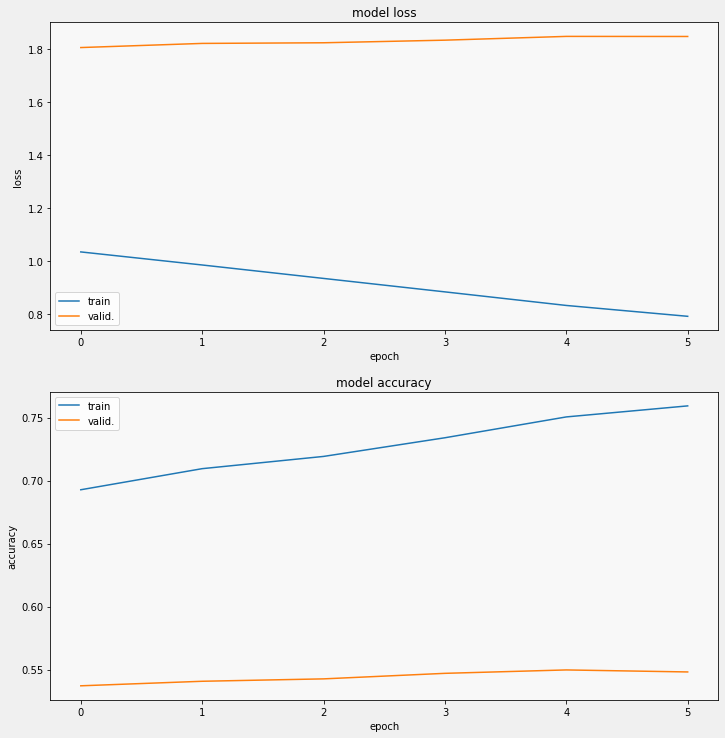

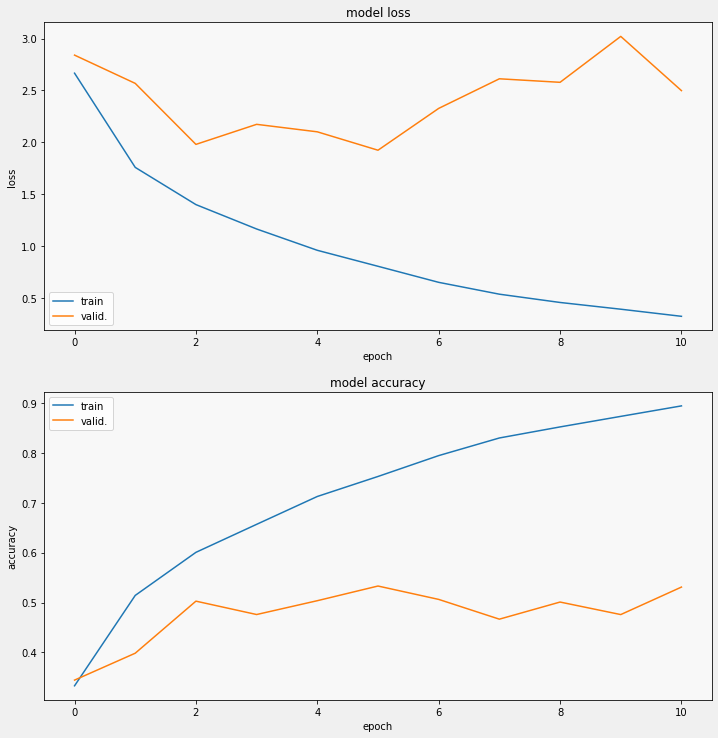

In [19]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history_enet_b7.history['loss'], history_enet_b7.history['val_loss'], 'loss', 211)
display_training_curves(history_enet_b7.history['accuracy'], history_enet_b7.history['val_accuracy'], 'accuracy', 212)

display_training_curves(history_dense201.history['loss'], history_dense201.history['val_loss'], 'loss', 211)
display_training_curves(history_dense201.history['accuracy'], history_dense201.history['val_accuracy'], 'accuracy', 212)

## Confusion Matrix

In [0]:
# TODO